In [ ]:
import pandas as pd

bed_file_path = '/home/share/huadjyin/home/lutianyu/01HIV/02data/downstream/annotation/GRCh38-cCREs.bed'
bed_data = pd.read_csv(bed_file_path, sep='\t', header=None)
print(bed_data.head())

In [ ]:
# 输入文件和输出文件
input_file = '/home/share/huadjyin/home/lutianyu/01HIV/02data/peak_gene/filter_peak_names.txt'
output_file = '/home/share/huadjyin/home/lutianyu/01HIV/02data/peak_gene/filter_peak_names.bed'

# 打开文件并处理
with open(input_file, 'r') as infile, open(output_file, 'w') as outfile:
    for line in infile:

        peak = line.strip()
        chrom, positions = peak.split(':')
        start, end = positions.split('-')
        
        start = int(start)
        end = int(end)
        
        outfile.write(f"{chrom}\t{start}\t{end}\n")

In [ ]:
# bedtools intersect -a /home/share/huadjyin/home/lutianyu/01HIV/02data/peak_gene/all_peak2gene_unique_peak_names.bed -b /home/share/huadjyin/home/lutianyu/01HIV/02data/downstream/annotation/GRCh38-cCREs.bed -wa -wb > /home/share/huadjyin/home/lutianyu/01HIV/02data/downstream/annotation/cCRE_overlaps.txt


挑出覆盖度最大的那个

In [ ]:
import pandas as pd
from collections import defaultdict

file_path = '/home/share/huadjyin/home/lutianyu/01HIV/02data/downstream/annotation/cCRE_overlaps.txt'
data = pd.read_csv(file_path, sep='\t', header=None)

def calculate_overlap(row):
    peak_start, peak_end = row[1], row[2]
    ccre_start, ccre_end = row[4], row[5]
    overlap_start = max(peak_start, ccre_start)
    overlap_end = min(peak_end, ccre_end)
    return max(0, overlap_end - overlap_start)

data['overlap'] = data.apply(calculate_overlap, axis=1)


In [ ]:
# 按peak分组，并选择覆盖度最大的行
best_matches = defaultdict(lambda: None)

for index, row in data.iterrows():
    peak_key = (row[0], row[1], row[2])
    current_overlap = row['overlap']
    if best_matches[peak_key] is None or current_overlap > best_matches[peak_key]['overlap']:
        best_matches[peak_key] = row

# 将结果转换为DataFrame
result = pd.DataFrame(best_matches.values())

# 删除覆盖度列
result = result.drop(columns=['overlap'])

# 保存结果到新文件
output_path = '/home/share/huadjyin/home/lutianyu/01HIV/02data/downstream/annotation/cCRE_best_matches.txt'
result.to_csv(output_path, sep='\t', index=False, header=False)


In [ ]:
# 提取第1、2、3和9列，并格式化
formatted_result = result.iloc[:, [0, 1, 2, 8]].copy()
formatted_result.columns = ['chr', 'start', 'end', 'cCRE']

# 格式化peakname：chr:start-end
formatted_result['peakname'] = formatted_result['chr'] + ':' + formatted_result['start'].astype(str) + '-' + formatted_result['end'].astype(str)

# 只保留peakname和cCRE两列
final_result = formatted_result[['peakname', 'cCRE']]

# 保存结果到新文件
output_path = '/home/share/huadjyin/home/lutianyu/01HIV/02data/downstream/annotation/cCRE_best_matches_process.txt'
final_result.to_csv(output_path, sep='\t', index=False, header=True)

In [1]:
import pandas as pd
all = pd.read_csv("/home/share/huadjyin/home/zhouxuanchi/HIV_code/peak2gene/no_gene_only_peak_ig/sig.csv", index_col = 0) # 只考虑spearman大于0.8的60个基因的peak
all = all.rename(columns={'Unnamed: 0': 'Peak'})

phast = pd.read_csv("/home/share/huadjyin/home/lutianyu/01HIV/02data/downstream/phastCons/peak_conservation_score.csv")

In [2]:
merged_df = pd.merge(
    phast[['Peak', 'ConservationScore']],  # 保留 phast_unique 的 Peak 和 ConservationScore
    all[['Peak', 'size']],                       # 保留 all 的 Peak 和 size
    on='Peak',                                   # 按 Peak 列匹配
    how='left'                                   # 左连接，保留 phast_unique 的所有 Peak
)

In [4]:
import pandas as pd

# 1. 读取cCRE注释文件
ccre = pd.read_csv(
    "/home/share/huadjyin/home/lutianyu/01HIV/02data/downstream/annotation/cCRE_best_matches_process.txt",
    sep='\t',  # 假设是制表符分隔
    header=None,  # 如果没有列名
    names=['Peak', 'cCRE']  # 指定列名
)

big_peaks = merged_df[merged_df['size'] == 'big'].copy()

result = pd.merge(
    big_peaks,
    ccre,
    on='Peak',
    how='left'
)
result

,Peak,ConservationScore,size,cCRE
0,chr1:11926239-11926740,0.237849,big,PLS
1,chr1:11979937-11980438,0.135060,big,PLS
2,chr1:12019124-12019625,0.073705,big,PLS
3,chr1:12132946-12133447,0.058964,big,dELS
4,chr1:12150411-12150912,0.168127,big,dELS
...,...,...,...,...
687,chrX:23781213-23781714,0.109761,big,pELS
688,chrX:24025247-24025748,0.535657,big,PLS
689,chrX:77786004-77786505,0.602191,big,PLS
690,chrX:77895259-77895760,0.333865,big,PLS


         cCRE  count  percentage                  label
4        dELS    282   40.869565     dELS: 282 (40.87%)
3         PLS    267   38.695652      PLS: 267 (38.70%)
5        pELS    137   19.855072     pELS: 137 (19.86%)
0          CA      2    0.289855          CA: 2 (0.29%)
1     CA-CTCF      1    0.144928     CA-CTCF: 1 (0.14%)
2  CA-H3K4me3      1    0.144928  CA-H3K4me3: 1 (0.14%)


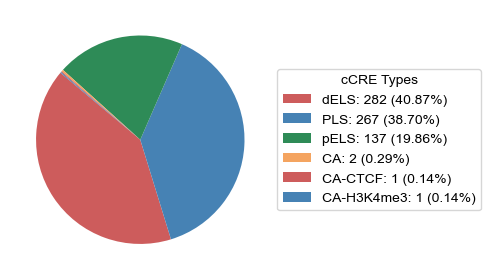

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ranksums
from statannotations.Annotator import Annotator
import matplotlib as mpl

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['font.sans-serif'] = "Arial"
mpl.rcParams['font.family'] = "sans-serif"
plt.rcParams['axes.unicode_minus']=False # negative minus sign

# 统计 cCRE 列的内容
ccre_counts = result['cCRE'].value_counts().reset_index()
ccre_counts.columns = ['cCRE', 'count']

# 处理带有逗号的内容
def process_ccre(ccre):
    # 将逗号替换为 " or "
    ccre = ccre.replace(',', ' or ')

    # 如果出现 "ELS or ELS"，直接改为 "ELS"
    if ccre == 'ELS or ELS':
        return 'ELS'
    if ccre == 'PLS or ELS':
        return 'ELS or PLS'
    return ccre

ccre_counts['cCRE'] = ccre_counts['cCRE'].apply(process_ccre)

# 重新统计处理后的 cCRE 数量
ccre_counts = ccre_counts.groupby('cCRE', as_index=False)['count'].sum()

# 按照数量从大到小排序
ccre_counts = ccre_counts.sort_values(by='count', ascending=False)  # 修改为降序排序

# 计算百分比
ccre_counts['percentage'] = ccre_counts['count'] / ccre_counts['count'].sum() * 100

# 生成标签
ccre_counts['label'] = ccre_counts.apply(lambda row: f"{row['cCRE']}: {row['count']} ({row['percentage']:.2f}%)", axis=1)

# 检查处理后的统计结果
print(ccre_counts)

# 绘制饼图
plt.figure(figsize=(5, 5))

custom_colors = [
    '#CD5C5C',  # 红色
    '#4682B4',  # 蓝色
    '#2E8B57',  # 绿色
    '#F4A460',  # 橙色
]

# 绘制饼图
wedges, texts = plt.pie(
    ccre_counts['count'],
    labels=None,  # 不显示默认标签
    colors=custom_colors,
    autopct=None,  # 不显示百分比
    startangle=140,  # 起始角度
    textprops={'fontsize': 12, 'color': 'black'}  # 文本属性
)

# 添加自定义标签
plt.legend(
    wedges,
    ccre_counts['label'],
    title="cCRE Types",
    loc="center left",
    bbox_to_anchor=(1, 0, 0.5, 1))  # 将图例放在饼图右侧

output_path = f'/home/share/huadjyin/home/lutianyu/01HIV/02data/downstream/peak2gene/cCREtype_bestmatch.pdf'
#plt.savefig(output_path, format='pdf', bbox_inches='tight')

# 显示图表
plt.tight_layout()
plt.show()